In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re
import json
import cv2
import albumentations
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss

from utils import *

In [2]:
from motion.detect_human import BBoxDataset

I used [sloth](https://github.com/cvhciKIT/sloth) to annotate the images.

You can find the config file in the `data` folder (`sloth_config.py`). The command to start `sloth` that I used was: `sloth --config sloth_config.py annotations.json`. I ran the command from within the directory where I stored my train images (both the `sloth_config.py` and `annotations.json` files were inside the directory as well).

In [3]:
SZ = 500

In [4]:
# https://github.com/albu/albumentations/blob/master/notebooks/example_bboxes.ipynb
def visualize(sample):
    
    return plot_im(sample[0].transpose(1, 2, 0).astype(np.uint8), sample[1])

def plot_im(img,bbox):
    x_min, y_min, x_max, y_max = map(int, bbox*SZ)
    print(img.shape)
    img = cv2.rectangle(img, (x_min, y_min), (x_max,y_max),(255, 0, 0),3)
    return img
    

In [5]:
trn_ds = BBoxDataset("coco/train2017_one_human.csv", size = SZ, type = "train")
# trn_ds = BBoxDataset("coco/val2017_one_human_train.csv", size = SZ, type = "train")
val_ds = BBoxDataset("coco/val2017_one_human_train.csv", size = SZ, type = "valid")
# val_ds = BBoxDataset("coco/val2017_one_human_val.csv", size = SZ, type = "valid")
# val_ds = BBoxDataset("motion/detect_human/one_sample_dataset.csv", size = SZ, type = "valid")
val_ds[0][0].mean()

Dataset has 27885 samples.
Dataset has 925 samples.


0.1951444

In [6]:
NUM_WORKERS=5
BS = 64

train_dl = DataLoader(trn_ds, BS, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
valid_dl = DataLoader(val_ds, BS, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

data_bunch = DataBunch(train_dl, valid_dl)

In [7]:
from motion.detect_human import HumanBBox

In [8]:
def intersection(preds, targs):
    # preds and targs are of shape (bs, 4), pascal_voc format
    max_xy = torch.min(preds[:, 2:], targs[:, 2:])
    min_xy = torch.max(preds[:, :2], targs[:, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]

def area(boxes): 
    return ((boxes[:, 2]-boxes[:, 0]) * (boxes[:, 3]-boxes[:, 1]))

def union(preds, targs):
    return area(preds) + area(targs) - intersection(preds, targs)

def IoU(preds, targs):
    return intersection(preds, targs) / union(preds, targs)

In [9]:
def l1(preds, targs):
    return L1Loss()(preds, targs).mean()
def iou_loss(preds, targs):
    return 1.0-IoU(preds, targs).mean()

def iou_custom_loss(preds, targs):
    loss = iou_loss(preds,targs)
    l1_loss = l1(preds,targs)
    loss += l1_loss
    return loss*100

In [10]:
learn = Learner(data_bunch, HumanBBox(ap_sz = 8), loss_func=iou_loss)
learn.metrics = [l1,iou_loss ]

In [12]:
learn.load('fastai_bbox_detect_humans_res34_arch3-1')

Learner(data=DataBunch;

Train: <motion.detect_human.bbox_dataset.BBoxDataset object at 0x7f58c305f7f0>;

Valid: <motion.detect_human.bbox_dataset.BBoxDataset object at 0x7f58c305f908>;

Test: None, model=HumanBBox(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (in_between): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=(8, 8))
      (mp): AdaptiveMaxPool2d(output_size=(8, 8))
    )
    (1): Flatten()
  )
  (head): Sequential(
    (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.25)
    (2): Linear(in_features=4096, out_features=512, bias=True)
    (3): ReLU(inplace)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.5)
    (6): Linear(in_features=512, out_features=4, bias=True

In [13]:
learn.validate()

[0.6118021, tensor(0.1399), tensor(0.6118)]

In [ ]:
learn.to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


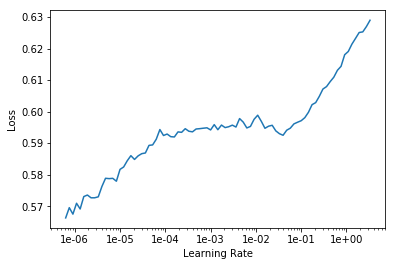

In [18]:
learn.lr_find(num_it = 100)
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,l1,iou_loss
1,0.598013,0.611580,0.139834,0.611580


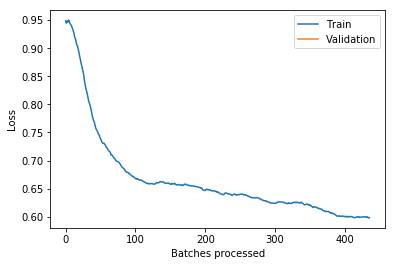

In [15]:
learn.recorder.plot_losses()

In [16]:
learn.validate()

[0.6115796, tensor(0.1398), tensor(0.6116)]

In [17]:
learn.save('fastai_bbox_detect_humans_res18_arch3-2')

In [17]:
preds, targs = learn.get_preds()

Let's take a look at the results.

In [18]:
predicted_bboxes = ((preds) * SZ).numpy()
targets = ((targs) * SZ).numpy()
predicted_bboxes

array([[ 84.72386 , 112.394485, 443.9387  , 446.24017 ],
       [ 23.246912,  36.82891 , 484.01364 , 463.94025 ],
       [ 99.93602 , 106.69424 , 410.2857  , 385.42816 ],
       [103.082085, 141.75334 , 434.97778 , 439.05304 ],
       ...,
       [ 72.96246 ,  91.23933 , 459.03265 , 461.86908 ],
       [ 32.5021  , 140.38902 , 247.28253 , 387.99747 ],
       [ 24.060707,  56.111553, 461.9653  , 458.59134 ],
       [ 83.24005 , 123.01602 , 343.60803 , 383.85413 ]], dtype=float32)

In [19]:
targs*SZ

tensor([[275., 193., 499., 457.],
        [  0.,  63., 499., 429.],
        [214., 203., 318., 411.],
        ...,
        [ 49.,  60., 221., 425.],
        [144.,  80., 499., 446.],
        [  0., 222., 255., 408.]])

In [20]:
def draw_bbox(img, bbox, target=None, color= (255, 0, 0), thickness=2):
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), 255, 3)
    if target is not None:
        x_min, y_min, x_max, y_max = map(int, target)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=3)
    return img

def visualize(sample, target = None):
    
    im = plot_im(sample[0].transpose(1, 2, 0).astype(np.uint8), sample[1])
    if target is not None:
        x_min, y_min, x_max, y_max = map(int, target)
        cv2.rectangle(im, (x_min, y_min), (x_max, y_max), color=(255,0,0), thickness=3)
    return im
    

def plot_im(img,bbox):
    x_min, y_min, x_max, y_max = map(int, bbox*SZ)
    print(img.shape)
    img = cv2.rectangle(img, (x_min, y_min), (x_max,y_max),(0, 255, 0),3)
    return img


(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)


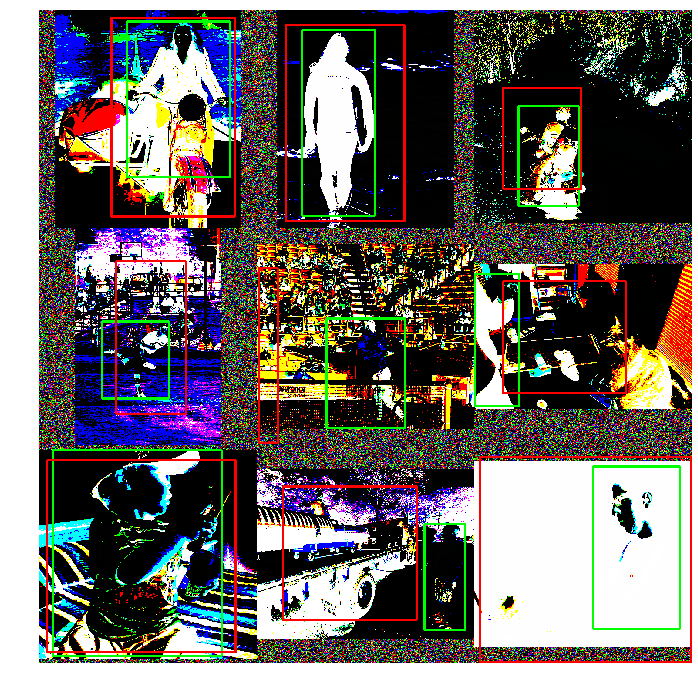

In [21]:
ims = np.stack([visualize(val_ds[i],target= predicted_bboxes[i]) for i in range(9,18)])
# ims = visualize(val_ds[0],target= predicted_bboxes[0])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))
# plt.imshow(np.stack(ims))